<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [34]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [35]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [36]:
#Two targets possible: target 1 = two_year_recid and target 2 = is_recid

#target1 = 'two_year_recid'
X1 = compas_2.drop(['two_year_recid', 'id', 'score_text', 'is_recid', 'is_violent_recid', 'sex', 'age_cat', 'race'],axis=1)
Y1 = compas_2['two_year_recid']

#target2 = "is_recid"
#X2 = compas_2.drop([target2, 'id', 'score_text', 'two_year_recid', 'is_violent_recid],axis=1)
#Y2 = compas_2[target2]


# Train Random Forest Classifier

In [37]:
#--------------Model with target 1: two_year recid----------------

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.3, shuffle = True, stratify = Y1)

model = RandomForestClassifier()
model.fit(X1_train, Y1_train)

#predictions
Y1hat = model.predict(X1_test)
len(Y1hat)

#---------------Model with target 2: is_recid--------------------

#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.3, shuffle = True, stratify = Y2)

#model = RandomForestClassifier()
#model.fit(X2_train, Y2_train)

#predictions
#Y2hat = model.predict(X2_test)
#len(Y2hat)


2165

# Collect the errors

In [38]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Y1hat.tolist()
predictions = predictions.set_index(X1_test.index)
predictions['true_class'] = Y1_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X1_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.8711
[[1077  112]
 [ 167  809]]


Selecting 4 labels (FP, FN, TP, TN)

In [39]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(entire_dataset)

      age  decile_score  priors_count  v_decile_score  priors_count.1  event  \
6449   53             2             3               1               3      0   
2712   35             8            14               5              14      1   
6113   59             1             1               1               1      0   
4523   20             4             0               6               0      1   
6233   26             4             1               3               1      0   
...   ...           ...           ...             ...             ...    ...   
3794   36             3             1               2               1      0   
546    44             3             1               1               1      0   
3290   23             9             0               9               0      1   
3972   57             2             6               2               6      0   
3235   46             4             4               1               4      0   

      sex_Female  sex_Male  age_cat_25 

In [40]:
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")

There's at least one occurrence of 1 in the column.


add categorical for error type

In [41]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

# Drop the original 'TP', 'FP', 'FN', 'TN' columns if needed
# data_all.drop(['TP', 'FP', 'FN', 'TN'], axis=1, inplace=True)

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'age_cat', 'race']], left_index=True, right_index=True)


print(entire_dataset)

      age  decile_score  priors_count  v_decile_score  priors_count.1  event  \
6449   53             2             3               1               3      0   
2712   35             8            14               5              14      1   
6113   59             1             1               1               1      0   
4523   20             4             0               6               0      1   
6233   26             4             1               3               1      0   
...   ...           ...           ...             ...             ...    ...   
3794   36             3             1               2               1      0   
546    44             3             1               1               1      0   
3290   23             9             0               9               0      1   
3972   57             2             6               2               6      0   
3235   46             4             4               1               4      0   

      sex_Female  sex_Male  age_cat_25 


Barchart 4 labels (FP, FN, TP, TN)

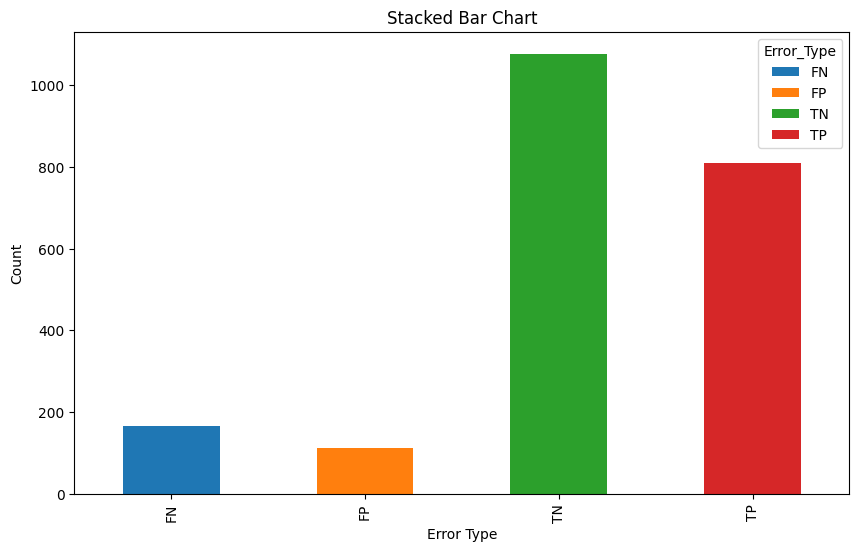

In [44]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart 4 labels per demographic group

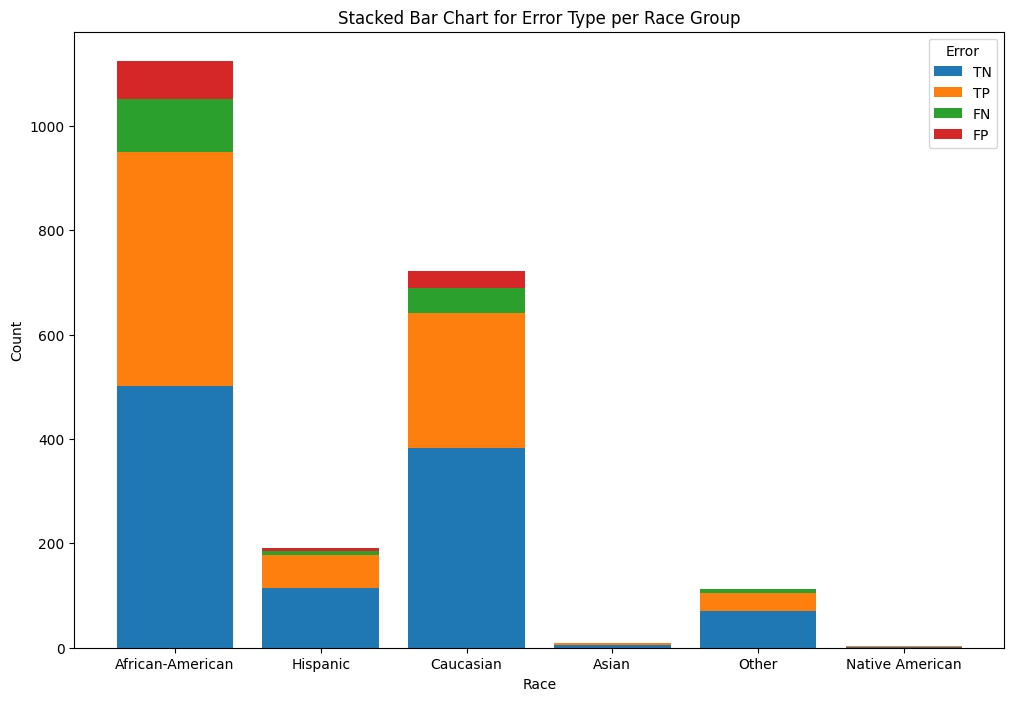

In [52]:
# Melt the DataFrame for easy plotting
melted_df = pd.melt(entire_dataset, id_vars=['race', 'Error_Type'], value_vars=['TP', 'TN', 'FN', 'FP'], var_name='Type', value_name='Count')

# Get unique races and error types
races = melted_df['race'].unique()
error_labels = melted_df['Error_Type'].unique()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through error labels and plot stacked bars for each race
bottom = np.zeros(len(races))
for error_label in error_labels:
    error_label_df = melted_df[melted_df['Error_Type'] == error_label]
    counts = error_label_df.groupby('race')['Count'].sum()

    # Make sure counts cover all races
    counts = counts.reindex(races, fill_value=0)

    ax.bar(races, counts, label=error_label, bottom=bottom)
    bottom += counts

# Add labels and title
ax.set_xlabel('Race')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart for Error Type per Race Group')
ax.legend(title='Error', loc='upper right')

# Show the plot
plt.show()




# Barchart error labels per sex

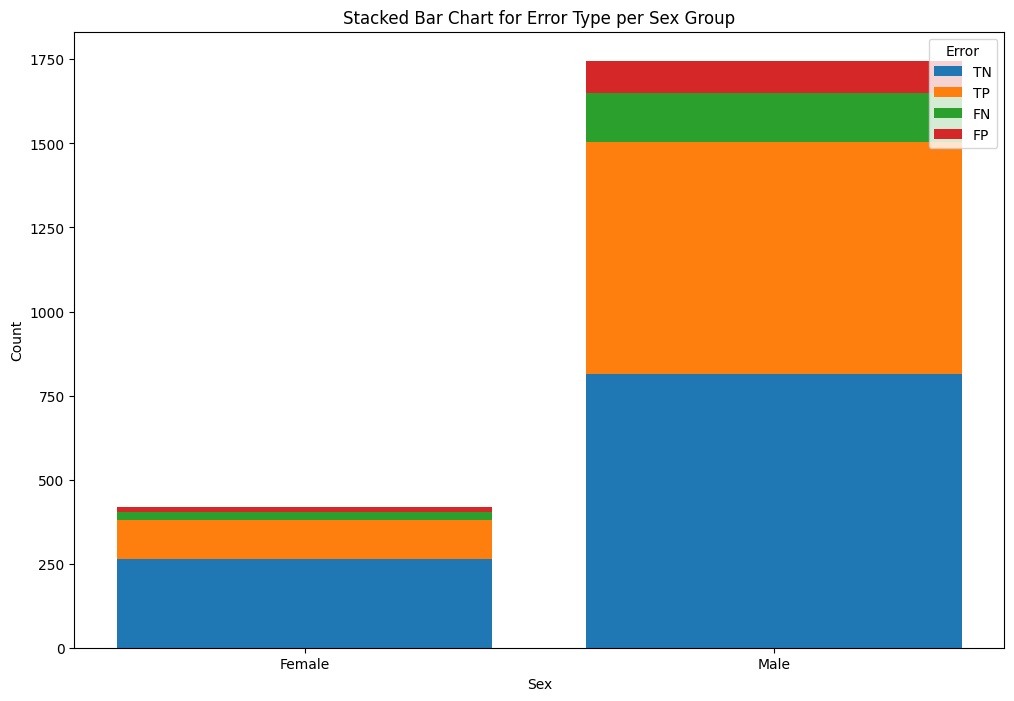

In [53]:
# Melt the DataFrame for easy plotting
melted_df_sex = pd.melt(entire_dataset, id_vars=['sex', 'Error_Type'], value_vars=['TP', 'TN', 'FN', 'FP'], var_name='Type', value_name='Count')

# Get unique sexes and error types
sexes = melted_df_sex['sex'].unique()
error_labels = melted_df_sex['Error_Type'].unique()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through error labels and plot stacked bars for each sex
bottom = np.zeros(len(sexes))
for error_label in error_labels:
    error_label_df = melted_df_sex[melted_df_sex['Error_Type'] == error_label]
    counts = error_label_df.groupby('sex')['Count'].sum()

    # Make sure counts cover all sexes
    counts = counts.reindex(sexes, fill_value=0)

    ax.bar(sexes, counts, label=error_label, bottom=bottom)
    bottom += counts

# Add labels and title
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Chart for Error Type per Sex Group')
ax.legend(title='Error', loc='upper right')

# Show the plot
plt.show()


# Scatterplot